## Worksheet 8

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

C:\Users\shann\AppData\Local\Temp\ipykernel_30332\2879525077.py:5: RuntimeWarning: divide by zero encountered in divide
  u = x/t


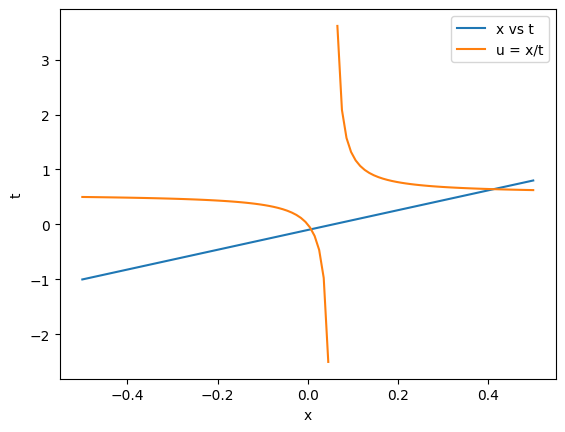

In [43]:
# x is an array of 100 points from 0 to 10
# t is an array of 100 points from 0 to 10  
x = np.linspace(-0.5,0.5, 100)
t = np.linspace(-1, 0.8, 100) 
u = x/t 
plt.plot(x, t, label='x vs t')
plt.xlabel('x')
plt.ylabel('t')
# plot the function u
plt.plot(x, u, label='u = x/t')     
plt.legend()

### Computational Fluid Mechanics I
 ####  Non-linear advection: FD vs. FV

a) i) The solution at x/t can be written in the case of the shock forming situation ($u_L > u_R$) as : 

![image.png](./image.png)


![Screenshot 2025-05-20 114057.png](./burgersShock.png)

In general, in case of a shock, the left side is moving faster than the right, as given above: $u_L > u_R$. Therefore, characteristics converge, since each characteristic travels as speed u and the wavefronts 'crash' into each other. This leads to a formation of a shock, i.e. a discontinous jump in the solution (we see the right plot, a discontinous solution at x/t = s)


The conservation law in conservative form gives us the Rankine-Hugoniot jump condition across a shock moving at speed s:

$ s = \frac{f(u_L)-f(u_R)}{u_L-u_R} = \frac{1/2 u^2_L -1/2 u^2_R}{u_L-u_R} = \frac{u_L + u_R}{2} $

So the solution is piecewise constant across the line x=st, or equivalently x/t=s. We can check this with the flux a x=0, t=0. Since the shock speed is s, we have to check wheter $0<s$  or larger s. At x=0, if $s>0$, then u(0,1) = $u_L$. If $s<0$, then u(0,1) = $u_R$.

a) ii) The solution can be written in the case of rarefaction wave as: 

![u(x,t)](./u_rarefaction.png)

with the flux location x=0 given by f(u(0,1))

![Screenshot 2025-05-20 114103.png](./BurgersRarefaction.png)

In the Rarefaction case, the left side moves faster than the right: $u_L < u_R$. The characteristic is spread out, as we can see in the left plot. The flow 'stretches', leading to a rarefaction wave. The solution therefore smootly interpolates bewteen $u_L$ and $u_R$. 

If we apply the method of characteristics for burgers equation :

$\frac{dx}{dt} = u(x,t)$

The initial condition is discontinous, so we assume a self-similar solution: 

$u(x,t) = u(\zeta)$, where $\zeta = \frac{x}{t}$ (as in plot of i))

We insert this into the conseervative form from the exercise sheet: 

$\delta_t u + \delta_x f(u) = 0$, with $f(u) = \frac{1}{2} u^2$, 

we get: 

$\delta_t u + \delta_x \left(\frac{1}{2}u^2 \right) = 0 
\rightarrow - \frac{\zeta}{t}u'(\zeta) + \frac{1}{t} u(\zeta) u'(\zeta) = 0 
\rightarrow u'(\zeta) (-\zeta + u(\zeta)) = 0 $

This gets us: $u(\zeta) = \zeta$


Therefore the solution is  within the fan as above: 

$u(x,t) = \frac{x}{t}, \text{for} u_L < \frac{x}{t} < u_R$ Which then yields the above solution : a continous profile


#### b i) Use the supplied notebook burgers fvm.ipynb and implement the missing flux functions for the finite volume method based on the solution to the Riemann problem given in a) for x ∈[0,1].

Finite Volume Method: 
- Integrated the conservation law over each cell
- requires numerical fluxes at cell interfaces to update the cell-averaged values 

We have:
1. the shock, here u(x,t) =$u_L$, if x/t < s, $u_R$ otherwise, with s = ($u_L +u_R / 2$) 

2. Rarefaction, at x0, which gives us: 

- u(0,t) = $u_L$, if $u_L > 0 $ 
- u(0,t) = $u_R$, if $u_R < 0 $
- u(0,t) = 0, if $u_L \leq 0 \leq u_R $


Therefore to compute the numerical flux at an interface, we solve the Rieman problem, by evaluating u(0,1), which is the state at the interface after a unit time and compute the flux f(u(0,1))

In [74]:
# Flux function
def flux(u):
    return 0.5 * u**2

# Riemann solver (Godunov flux for Burgers' equation)
def godunov_flux(uL, uR):
    if uL > uR:
        # Shock
        s = 0.5 * (uL + uR)
        u = uL if s > 0 else uR
        
        return flux(u)
    else:
        # Rarefaction
        if uL > 0: 
            u = uL
        elif uR < 0:
            u = uR  
        else:
            u = 0.0 
        return flux(u)

# Initial condition: step function
def initial_condition(x, uL, uR):
    return np.where(x < 0.5, uL, uR)

# Finite volume solver
def burgers_fvm(uL, uR, N=100, CFL=0.9, T=0.3):
    x = np.linspace(0, 1, N)
    dx = x[1] - x[0]
    u = initial_condition(x, uL, uR)
    
    t = 0.0
    while t < T:
        # Compute max speed for CFL condition
        max_speed = np.max(np.abs(u))
        dt = CFL * dx / max_speed 
        if t + dt > T:
            dt = T - t

        # Compute numerical fluxes
        fluxes = np.zeros(N+1)
        for i in range(1, N):
            fluxes[i] = godunov_flux(u[i-1], u[i])

        # Update solution
        u[1:-1] -= dt/dx * (fluxes[2:-1] - fluxes[1:-2])


        t += dt
        #print(f"Time: {t:.2f}, dt: {dt:.4f}")


    return x, u


Plot the solution for the case of a shock wave and a rarefaction wave: (1) showing u as a function of x at a few select times

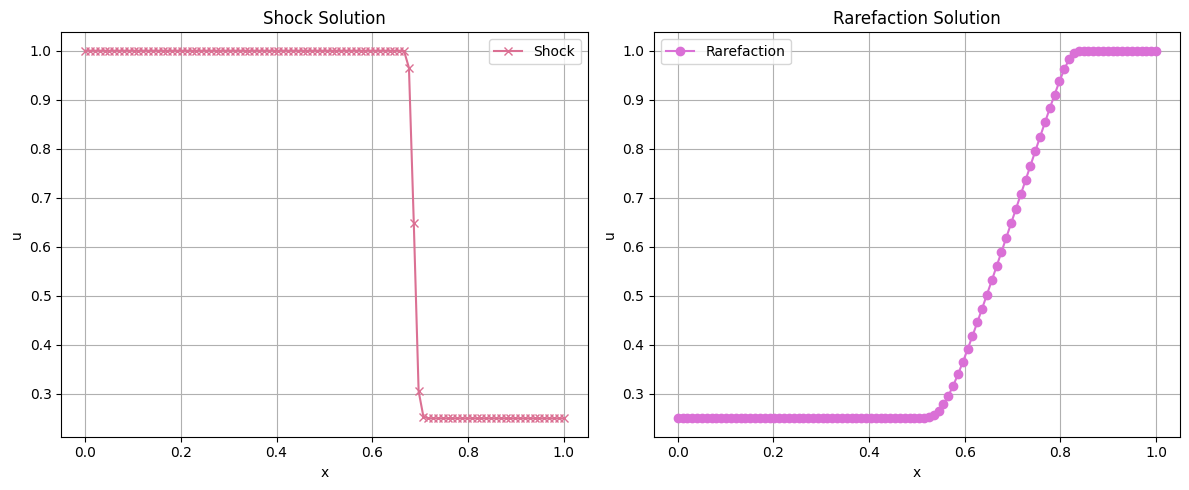

In [80]:
# Setup parameters : 
T = 0.3
N = 100

# Shock wave initial condition
uLs = 1.0
uRs = 0.25
xs, us = burgers_fvm(uLs, uRs, N=100)

# Rarefaction wave initial condition
uLr = 0.25
uRr = 1
xR, uR = burgers_fvm(uLr, uRr, N=100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(xs, us, 'x-', label='Shock', color='palevioletred')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Shock Solution')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xR, uR, 'o-',label='Rarefaction', color='orchid')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Rarefaction Solution')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

 Plot the solution for the case of a shock wave and a rarefaction wave:showing the full space-time diagram of the solution, i.e. as an image with t on the x-axis and x on the y-axis, and the colour indicating the value of u. 

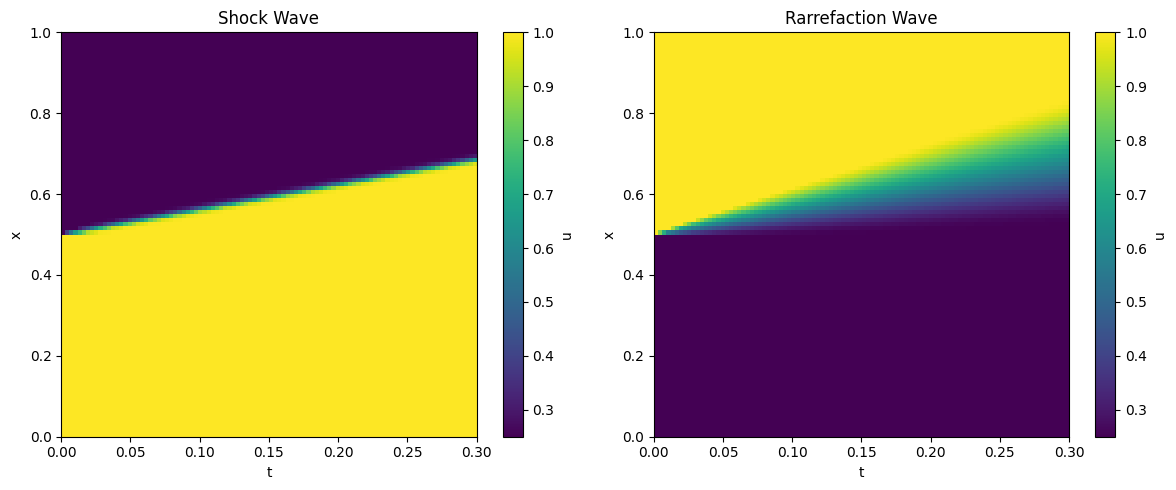

In [108]:
u_space_time_S = np.zeros((N, N))
u_space_time_R = np.zeros((N, N))
for j in range(N):
    u_space_time_S[:, j] = burgers_fvm(uLs, uRs, N=N, T=t[j])[1]
    u_space_time_R[:, j] = burgers_fvm(uLr, uRr, N=N, T=t[j])[1]


t = np.linspace(0, T, N)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(u_space_time_S, extent=[t[0], t[-1], xs[0], xs[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Shock Wave')


plt.subplot(1, 2, 2)
plt.imshow(u_space_time_R, extent=[t[0], t[-1], xR[0], xR[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Rarrefaction Wave')
plt.tight_layout()
plt.show()

In the left panel, the transition is sharp and the scheme captures the shock clearly, as we would expect it.
In the right panel, we see the diffuse transition region, as predicted by the Rarrefaction case.